In [1]:
import matplotlib.pyplot as plt
from icecream import ic

import torch
from torch import nn, Tensor
from torch.nn import functional as F

# torch.manual_seed(42) # DON'T DO THIS FOR NOW
# torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

from src.train import tonfig
DEVICE = torch.device("cuda")

# Test Model

## Forward pass

In [2]:
from src.model import get_magnet_model
from src.preprocess_ops import PreProOps
from src.music_bench import (
    MAX_SEC, 
    shuffle_preserve_order, 
    QCODING_LEN,
)
from src.train import PreProDataset

In [3]:
ctx = (
        torch.autocast(
                device_type="cuda" if "cuda" in DEVICE.type else "cpu",
                dtype={"bfloat16": torch.bfloat16,
                       "float16" : torch.float16}[tonfig.dtype]
        )
    )

In [4]:
preprocess_ops = PreProOps(
    max_sec=QCODING_LEN,
    print_info=True,
    device=DEVICE.type,
    compile=False,
    autocast=ctx
)

/home/vvy/Desktop/repos/MAGNeT/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [5]:
cond_tok = preprocess_ops.tokenize(
    ["Hey, how are you doing today?", "I'm doing great, thanks for asking!"],
)
cond_tok["input_ids"], cond_tok["input_ids"].shape

(tensor([[9459,    6,  149,   33,   25,  692,  469,   58,    1,    0,    0],
         [  27,   31,   51,  692,  248,    6, 2049,   21, 3558,   55,    1]]),
 torch.Size([2, 11]))

In [6]:
cond_tok["attention_mask"], cond_tok["attention_mask"].shape

(tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 torch.Size([2, 11]))

In [7]:
cond_tensor = preprocess_ops.get_conditioned_tensor(cond_tok)
cond_tensor, cond_tensor.shape

(tensor([[[ 0.0798, -0.0365, -0.1036,  ..., -0.2099, -0.1402, -0.1041],
          [ 0.1598,  0.1184, -0.2387,  ..., -0.0835, -0.0984, -0.1727],
          [-0.0956,  0.0361,  0.2813,  ..., -0.0334,  0.2108, -0.0097],
          ...,
          [ 0.0439,  0.0736, -0.0768,  ..., -0.0767,  0.0265, -0.0009],
          [ 0.1242, -0.0135,  0.2864,  ..., -0.0929,  0.0952, -0.1670],
          [ 0.1435,  0.0108,  0.2966,  ..., -0.0486,  0.0798, -0.1602]],
 
         [[ 0.1367, -0.1287,  0.1267,  ...,  0.1340, -0.1315, -0.0488],
          [ 0.1183,  0.1225, -0.1890,  ...,  0.0422,  0.0518, -0.2713],
          [-0.0215,  0.1384, -0.2083,  ...,  0.2156, -0.2183,  0.0926],
          ...,
          [-0.1774, -0.0601,  0.2032,  ...,  0.1289, -0.0658,  0.2017],
          [-0.0895,  0.0003, -0.0262,  ...,  0.0706,  0.0023, -0.1166],
          [ 0.0512,  0.0577, -0.0301,  ...,  0.0092,  0.0330, -0.0518]]],
        device='cuda:0'),
 torch.Size([2, 11, 512]))

In [8]:
prepro_ds = iter(PreProDataset(
    wav_paths=[["data/MusicBench/datashare/data_aug2/_0-2meOf9qY_4.wav", "data/MusicBench/datashare/data_aug2/zzNdwF40ID8_3.wav"],
               ["data/MusicBench/datashare/data_aug2/_0-2meOf9qY_4.wav", "data/MusicBench/datashare/data_aug2/zzNdwF40ID8_3.wav"]],
    texts=["Hey, how are you doing today?", "I'm doing great, thanks for asking!"],
    audio_pad_id=1024,
    device=DEVICE.type,
    preprocess_ops=preprocess_ops,
    qcoding_len=QCODING_LEN,
).iter_batches())

In [9]:
a = next(prepro_ds)
a[0]["qcode"].shape, a[0]["mask"].shape, a

(torch.Size([2, 4, 750]),
 torch.Size([2, 4, 750]),
 ({'qcode': tensor([[[ 121,   62,   62,  ..., 1024, 1024, 1024],
            [ 913,  424,  424,  ..., 1024, 1024, 1024],
            [ 937,  786,  786,  ..., 1024, 1024, 1024],
            [ 673,  673,  673,  ..., 1024, 1024, 1024]],
   
           [[ 131,  224,  310,  ..., 1024, 1024, 1024],
            [ 422,    0,  653,  ..., 1024, 1024, 1024],
            [ 316,  798,  798,  ..., 1024, 1024, 1024],
            [ 721,  818,  721,  ..., 1024, 1024, 1024]]], device='cuda:0'),
   'mask': tensor([[[ True,  True,  True,  ..., False, False, False],
            [ True,  True,  True,  ..., False, False, False],
            [ True,  True,  True,  ..., False, False, False],
            [ True,  True,  True,  ..., False, False, False]],
   
           [[ True,  True,  True,  ..., False, False, False],
            [ True,  True,  True,  ..., False, False, False],
            [ True,  True,  True,  ..., False, False, False],
            [ True,

In [10]:
cond_tensor, cond_tensor.shape

(tensor([[[ 0.0798, -0.0365, -0.1036,  ..., -0.2099, -0.1402, -0.1041],
          [ 0.1598,  0.1184, -0.2387,  ..., -0.0835, -0.0984, -0.1727],
          [-0.0956,  0.0361,  0.2813,  ..., -0.0334,  0.2108, -0.0097],
          ...,
          [ 0.0439,  0.0736, -0.0768,  ..., -0.0767,  0.0265, -0.0009],
          [ 0.1242, -0.0135,  0.2864,  ..., -0.0929,  0.0952, -0.1670],
          [ 0.1435,  0.0108,  0.2966,  ..., -0.0486,  0.0798, -0.1602]],
 
         [[ 0.1367, -0.1287,  0.1267,  ...,  0.1340, -0.1315, -0.0488],
          [ 0.1183,  0.1225, -0.1890,  ...,  0.0422,  0.0518, -0.2713],
          [-0.0215,  0.1384, -0.2083,  ...,  0.2156, -0.2183,  0.0926],
          ...,
          [-0.1774, -0.0601,  0.2032,  ...,  0.1289, -0.0658,  0.2017],
          [-0.0895,  0.0003, -0.0262,  ...,  0.0706,  0.0023, -0.1166],
          [ 0.0512,  0.0577, -0.0301,  ...,  0.0092,  0.0330, -0.0518]]],
        device='cuda:0'),
 torch.Size([2, 11, 512]))

In [11]:
magnet_model = get_magnet_model().to(DEVICE)

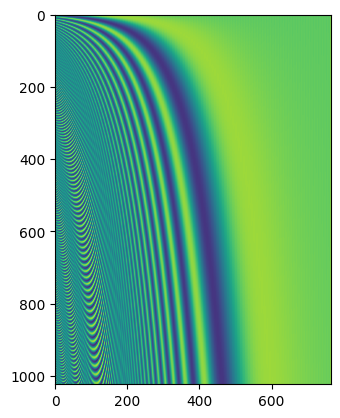

In [12]:
def get_sinusoidal_positional_embeddings(maxlen:int, dim:int) -> Tensor:
    import numpy as np
    p, i = np.meshgrid(np.arange(float(maxlen)), np.arange(dim/2.)*2)
    theta = (p/1e4**(i/dim)).T

    pos_emb = np.stack([np.sin(theta), np.cos(theta)], axis=-1)
    pos_emb = pos_emb.reshape((maxlen, dim))[None] # (B=1, maxlen, dim)
    return torch.from_numpy(pos_emb)

pos_emb = get_sinusoidal_positional_embeddings(1024, 764)
plt.imshow(pos_emb[0].cpu().numpy())
plt.show()

# Test Training:

In [13]:
from src.music_bench import AUDIO_TXT_PATH, ioPathTextDs
from src.train import PreProDataset, MagnetTrainer
from src.utils.lr_scheduler import CosineDecayWithWarmup

import time
import numpy as np

# Try Overfitting lil batch

In [14]:
dataset = ioPathTextDs(
    save_path=AUDIO_TXT_PATH,
    batch_size=2,
    split_float=0.9,
    return_ds=True
)
x_train, y_train = dataset["train"]
train_iterator = iter(PreProDataset(
    wav_paths=x_train[4:5],
    texts=y_train[4:5],
    audio_pad_id=1024,
    device=DEVICE.type,
    qcoding_len=QCODING_LEN,
    preprocess_ops=preprocess_ops,
).iter_batches())
next(train_iterator)

Dataset is preprocessed.


({'qcode': tensor([[[ 437,   20,  531,  ...,  531,  613,  713],
           [ 397,  792,  463,  ...,  695,  537,  925],
           [  29,   87,  838,  ...,  952,  253,  320],
           [ 711,  236,  120,  ...,  409,  377,  197]],
  
          [[  59,   59,  151,  ...,  428,  192, 1008],
           [ 245,  367,  308,  ...,  851,  851,  297],
           [ 828,   66, 1006,  ...,  711,  458,  357],
           [ 129,  707,  166,  ...,  341,  584,  388]]], device='cuda:0'),
  'mask': tensor([[[True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True]],
  
          [[True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True]]], device='cuda:0')},
 ['This country blues instrumental song incorporates a

In [15]:
next(train_iterator)

({'qcode': tensor([[[ 437,   20,  531,  ...,  531,  613,  713],
           [ 397,  792,  463,  ...,  695,  537,  925],
           [  29,   87,  838,  ...,  952,  253,  320],
           [ 711,  236,  120,  ...,  409,  377,  197]],
  
          [[  59,   59,  151,  ...,  428,  192, 1008],
           [ 245,  367,  308,  ...,  851,  851,  297],
           [ 828,   66, 1006,  ...,  711,  458,  357],
           [ 129,  707,  166,  ...,  341,  584,  388]]], device='cuda:0'),
  'mask': tensor([[[True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True]],
  
          [[True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True],
           [True, True, True,  ..., True, True, True]]], device='cuda:0')},
 ['This country blues instrumental song incorporates a

In [16]:
print(sum(p.numel() for p in magnet_model.parameters() if p.requires_grad)/1e6, "Million Parameters")

37.833728 Million Parameters


In [17]:
magnet_trainer = MagnetTrainer(
    magnet_model=magnet_model,
    preprocess_ops=preprocess_ops,
    config=tonfig
)

get_lr = CosineDecayWithWarmup(
    warmup_steps=tonfig.warmup_steps,
    max_learning_rate=tonfig.max_learning_rate,
    decay_steps=tonfig.decay_steps,
    min_learning_rate=tonfig.min_learning_rate
)

scaler = torch.cuda.amp.GradScaler(enabled=(tonfig.dtype=="float16"))

optimizer = magnet_model.configure_optimizers(
    weight_decay=tonfig.weight_decay,
    learning_rate=5e-4,
    betas=(tonfig.beta1, tonfig.beta2),
    device_type="cuda" if "cuda" in DEVICE.type else "cpu"
)

In [18]:
losses, accuracies = [], []
def test_train():
    audio_input, cond_text = next(train_iterator)

    print("Training about to start...")
    t0 = time.time()
    for step in range(0, 2000):
        # set learning rate for all params
        lr = 5e-4
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        # gradient accumulation step
        for mini_step in range(tonfig.num_grad_accumalation_steps):
            with ctx:
                loss, accuracy = magnet_trainer.mini_train_step(
                    audio_input=audio_input, padded_cond_str=cond_text
                )
                loss /= tonfig.num_grad_accumalation_steps
                # async prefetch immediately
                audio_input, cond_text = next(train_iterator)

            # keeps on scaling and adding gradients when calling backward
            scaler.scale(loss).backward()

        if tonfig.clipnorm is not None:
            # unscale the gradients
            scaler.unscale_(optimizer)
            # clips gradients in-place to grad norm
            nn.utils.clip_grad_norm_(magnet_model.parameters(), max_norm=tonfig.clipnorm)

        # calls unscale to the optimizer unless already called, checks for infs and nans as a part of unscale_
        # calls optimizer.step on unscaled grads if no infs and nans else optimizer.step is skipped
        scaler.step(optimizer)
        # Update the scale factor
        scaler.update()

        # flush grads to save memory
        optimizer.zero_grad(set_to_none=True)

        # some logging
        t1 = time.time()
        dt = t1-t0
        t0 = t1
        if step % tonfig.log_interval == 0:
            # multiply as loss was scaled for gradient accumulation
            lossf = loss.item() * tonfig.num_grad_accumalation_steps
            print(
                f"| Step: {step} || Loss: {lossf:.4f} || Accuracy: {accuracy:.4f} |"
                f"| LR: {lr:e} || dt: {dt*1000:.2f}ms |"
            )
            losses.append(lossf); accuracies.append(accuracy.cpu().item())
    return losses, accuracies

losses, accuracies = test_train()

Training about to start...
| Step: 0 || Loss: 7.1062 || Accuracy: 0.0013 || LR: 5.000000e-04 || dt: 97.64ms |
| Step: 1 || Loss: 6.5517 || Accuracy: 0.0042 || LR: 5.000000e-04 || dt: 42.92ms |
| Step: 2 || Loss: 7.1145 || Accuracy: 0.0152 || LR: 5.000000e-04 || dt: 47.38ms |
| Step: 3 || Loss: 6.8934 || Accuracy: 0.0133 || LR: 5.000000e-04 || dt: 45.89ms |
| Step: 4 || Loss: 7.1061 || Accuracy: 0.0072 || LR: 5.000000e-04 || dt: 45.75ms |
| Step: 5 || Loss: 6.8666 || Accuracy: 0.0087 || LR: 5.000000e-04 || dt: 46.95ms |
| Step: 6 || Loss: 7.0922 || Accuracy: 0.0113 || LR: 5.000000e-04 || dt: 46.07ms |
| Step: 7 || Loss: 6.3671 || Accuracy: 0.0155 || LR: 5.000000e-04 || dt: 48.01ms |
| Step: 8 || Loss: 6.1371 || Accuracy: 0.0238 || LR: 5.000000e-04 || dt: 46.19ms |
| Step: 9 || Loss: 5.9893 || Accuracy: 0.0313 || LR: 5.000000e-04 || dt: 46.04ms |
| Step: 10 || Loss: 6.2129 || Accuracy: 0.0290 || LR: 5.000000e-04 || dt: 45.95ms |
| Step: 11 || Loss: 6.1259 || Accuracy: 0.0258 || LR: 5.000

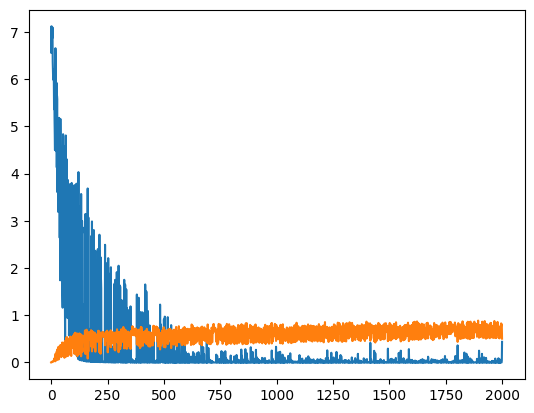

In [19]:
plt.plot(losses)
plt.plot(accuracies)
plt.show()

In [20]:
min(losses), max(accuracies), losses.index(min(losses)), accuracies.index(max(accuracies)) # hmmm, ok but accuracy should be 1.0

(1.670519486651756e-05, 0.8865000009536743, 1014, 1893)

In [ ]:
# class TestMagnetTrainer(MagnetTrainer):
#     def __init__(
#         self, 
#         magnet_model:nn.Module, 
#         preprocess_ops:PreProOps, 
#         config:tonfig
#     ):
#         super().__init__(magnet_model, preprocess_ops, config)

#     def test__get_number_of_spans_to_mask(self, T=100, spanlen=3):
#         self.num_span_to_mask =  super()._get_number_of_spans_to_mask(T, spanlen)
#         print("self.num_span_to_mask", self.num_span_to_mask)
#         return self.num_span_to_mask

In [ ]:
# test_trainer = TestMagnetTrainer(magnet_model, preprocess_ops, tonfig)
# num_span_mask = test_trainer.test__get_number_of_spans_to_mask()

In [ ]:
# rand = torch.rand((11, 100))

In [ ]:
# def _get_spanned_mask(mask_rates:Tensor, seq_len:int):
#         """
#         Returns a mask of shape (B, T) where the True value will be masked.\n
#         Uses `mask_rates` and `self._num_spans_to_mask`\n
#         Args:
#             `mask_rates`: Tensor => mask_probabilities of shape (B,)
#             `T`: int => length of sequence
#         Returns:
#             `mask`: Tensor => mask of shape (B, T)
#         """
#         B = len(mask_rates)

#         indexes = torch.round(mask_rates*100).to(torch.int64) # indexes to take from num_spans_to_mask # (B,)
#         # contains number of spans to mask
#         batched_num_spans = torch.tensor(num_span_mask).gather(dim=0, index=indexes).clip(min=1)
        
#         batch_randperm = rand.argsort(-1) # rand integers from 0 to T
#         mask = batch_randperm < batched_num_spans[..., None] # contains `batched_num_spans` number of Trues
#         shifted_mask = mask.clone()
#         for _ in range(3-1):
#             shifted_mask = torch.concat((torch.zeros((B, 1)).bool(), shifted_mask[:, :-1]), dim=-1)
#             mask = torch.logical_or(mask, shifted_mask)
#         return mask # (B, T) # True value will be masked

# my_mask = _get_spanned_mask(torch.tensor([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), 100)
# my_mask.sum(-1)

In [ ]:
# def _magnet_restricted_att_mask(shape:tuple, windows:tuple, dtype:torch.dtype=torch.float32):
#         create_as = dtype if dtype is not torch.bfloat16 else torch.float32
#         mask = torch.full(
#             shape, dtype=create_as, fill_value=1
#         )

#         num_queries, num_keys = shape[-2:]
#         shift = num_keys - num_queries

#         mask = torch.triu(mask, diagonal=shift - windows[0])
#         mask = torch.tril(mask, diagonal=shift + windows[1])
#         mask = torch.log(mask)
#         return mask.to(dtype)

# my_att_mask = _magnet_restricted_att_mask((10, 10), (3, 3))

In [ ]:
# def _magnet_cross_entropy(
#         y_true:Tensor,    # (B, nq, T)
#         y_pred:Tensor,    # (B, nq, T, cardinality) # logits
#         loss_mask:Tensor, # (B, nq, T) # take loss only on masked tokens (True value)
#         phase:int
#     ):
#         y_true, loss_mask = y_true[:, phase], loss_mask[:, phase] # (B, T)
#         y_pred = y_pred[:, phase] # (B, T, cardinality)

#         # take loss only on masked tokens (True value) # so -1 the False values
#         y_true[loss_mask==False] = -1
#         """
#         print("NUM -1", (y_true==-1).sum(-1))
#         print("y_true", y_true.shape, "\n\ny_pred\n", y_pred.shape, "\n\nloss_mask\n", loss_mask.shape, "\n\n")
#         print("y_pred.movedim(-1, -2)\n", y_pred.movedim(-1, -2).shape, "\n\ny_true\n", y_true, "\n\n")
#         """
#         loss = F.cross_entropy(
#             y_pred.movedim(-1, -2), # (B, num_classes=cardinatlity, d1=T) <= (B, T, cardinality)
#             y_true, # (B, d1=T)
#             ignore_index=-1
#         )
#         return loss

___

In [ ]:
# def _calc_mean_maskrate_to_u_LUT(T: int):
#         L = 3

#         u2mean = [0.0]  # mean mask rate is 0.0 for u = 0
#         v = (T - L) / float(T)
#         for u in range(1, T):
#             u2mean.append(1 - v)
#             v *= (T - L - u) / (T - u)  # Overflow-safe implementation of choose(T - L, u) / choose(T, u).

#         mean2u = []
#         for maskperc in range(101):
#             maskrate = maskperc / float(100)
#             u = int(np.searchsorted(u2mean, maskrate))
#             mean2u.append(u)

#         return mean2u

# actual = _calc_mean_maskrate_to_u_LUT(100)
# print("actual", actual)

In [ ]:
# num_span_mask == actual

In [ ]:
# from einops import rearrange
# def _spans_mask(mask_probs: torch.Tensor, B: int, T: int, device: torch.device) -> torch.Tensor:
#         """ Construct a spans mask with masking rates defined by mask_probs,
#             where the atomic span length ( > 1 ) is defined by cfg.masking.span_len.
#         Args:
#             mask_probs (torch.Tensor): The desired masking rate per sample, of shape [B,]
#             B (int): Batch size.
#             T (int): Sequence length.
#             device (torch.device): device of the output tensor
#         Returns:
#             (torch.Tensor): A spans mask of shape [B, T]
#         """
#         L = 3
#         rounded_probs = torch.round(100 * mask_probs).long()
#         k = torch.tensor(actual)[rounded_probs].clamp(min=1)  # k is the number of span starts

#         # sample random span starts
#         batch_randperm = rand.argsort(dim=-1)
#         mask = batch_randperm < rearrange(k, 'b -> b 1')
#         B, T = mask.shape
#         shifted_mask = mask.clone()
#         for _ in range(L - 1):
#             shifted_mask = torch.concat((torch.full((B, 1), False, device=device), shifted_mask[:, :-1]), dim=1)
#             mask = torch.logical_or(mask, shifted_mask)

#         return mask
# probs = torch.tensor([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# actual_mask = _spans_mask(probs, len(probs), 100, torch.device("cpu"))
# actual_mask

In [ ]:
# actual_mask.sum(dim=-1), my_mask.sum(-1)

In [ ]:
# def restricted_context_attn_mask(seq_len: int, device: torch.device, dtype: torch.dtype) -> torch.Tensor:
#         """Creates a restricted attention mask (local attention map) where the context
#            is determined by self.subcodes_context.
#         Args:
#             seq_len (int): token sequence length.
#             device (torch.device): device of the output tensor.
#             dtype (torch.dtype): data type of the output tensor.
#         Returns:
#             torch.Tensor: The restricted attention mask.
#         """
#         # Return a context restricted non-causal att mask
#         queries_pos = torch.arange(seq_len, device=device).view(-1, 1)
#         keys_pos = torch.arange(seq_len, device=device).view(1, -1)

#         delta = queries_pos - keys_pos
#         valid = torch.abs(delta) <= 5
#         return torch.where(
#             valid,
#             torch.zeros([], device=device, dtype=dtype),
#             torch.full([], float('-inf'), device=device, dtype=dtype))

# actual_att_mask = restricted_context_attn_mask(10, torch.device("cpu"), torch.float32)
# actual_att_mask

In [ ]:
# actual_att_mask==actual_att_mask

In [ ]:
# def _compute_cross_entropy_magnet(logits: torch.Tensor,
#                                       targets: torch.Tensor, mask: torch.Tensor, stage: torch.Tensor) -> torch.Tensor:
#     """ Compute cross entropy between multi-codebook targets and model's logits.
#     The cross entropy is computed only on a specific codebook, defined by the stage argument.
#     Valid timesteps for each codebook are pulled from the mask, where invalid
#     timesteps are set to 0.

#     Args:
#         logits (torch.Tensor): Model's logits of shape [B, K, T, card].
#         targets (torch.Tensor): Target codes, of shape [B, K, T].
#         mask (torch.Tensor): Mask for valid target codes, of shape [B, K, T].
#         stage (torch.Tensor): The codebook (idx) that is being optimized, as a scalar tensor.
#     Returns:
#         ce (torch.Tensor): Cross entropy of the codebook that is being optimized.
#     """
#     assert logits.shape[:-1] == targets.shape
#     assert mask.shape == targets.shape
#     ce = torch.zeros([], device=targets.device)
#     logits_k = logits[:, stage, ...].contiguous().view(-1, logits.size(-1))  # [B x T, card]
#     targets_k = targets[:, stage, ...].contiguous().view(-1)  # [B x T]
#     mask_k = mask[:, stage, ...].contiguous().view(-1)  # [B x T]

#     IGNORE_IDX = -1
#     targets_k[~mask_k] = IGNORE_IDX
#     q_ce = F.cross_entropy(logits_k, targets_k, ignore_index=IGNORE_IDX)

#     ce += q_ce
#     return ce

In [ ]:
# y_true = torch.randint(0, 1024+1, (1, 4, 100))
# y_pred = torch.rand((1, 4, 100, 1024))
# mask = torch.randint(0, 2, (1, 4, 100)).bool()

# for phase in range(4):
#     actual_loss = _compute_cross_entropy_magnet(y_pred, y_true, mask, phase)
#     my_loss = _magnet_cross_entropy(y_true, y_pred, mask, phase)
#     ic(actual_loss, my_loss)

## Try Overfiting lil batch

### `lr = 0.0`
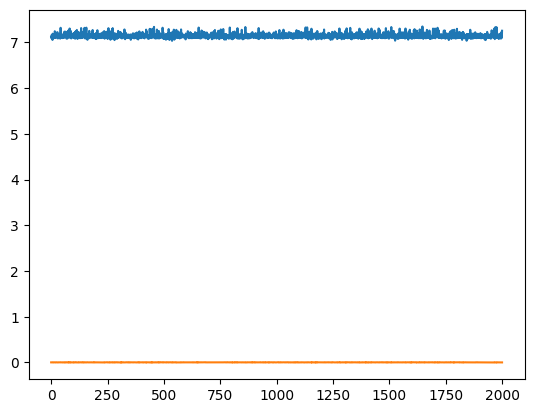
### `lr = 1e-4`
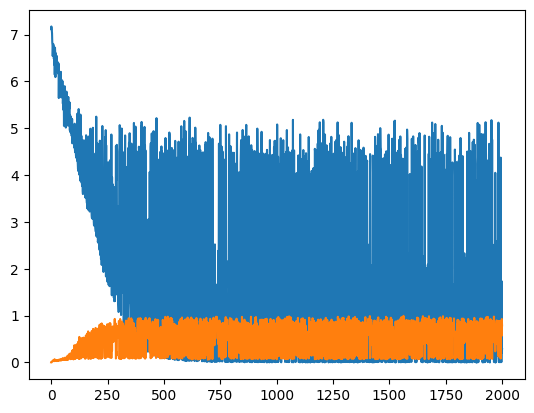
### `lr = 1e-5`
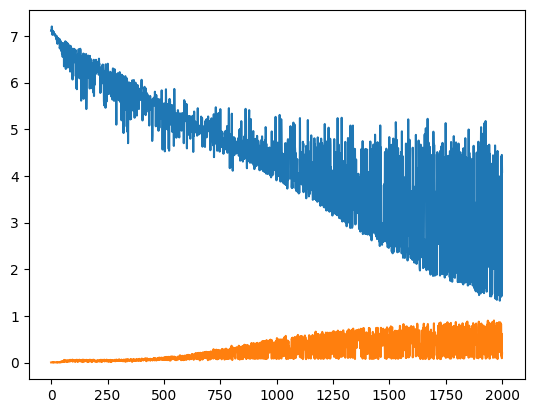
### `lr = 1e-6`
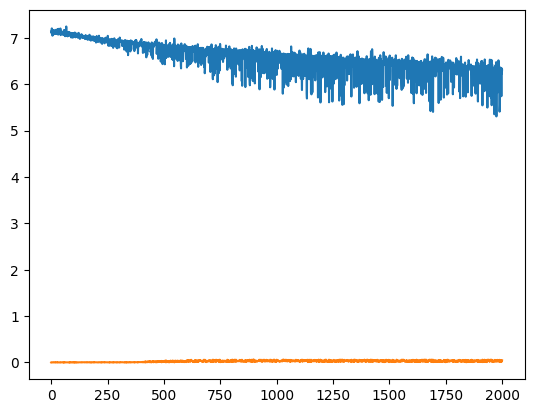

# Found a bug; no pos emb... added it; `lr = 5e-4`

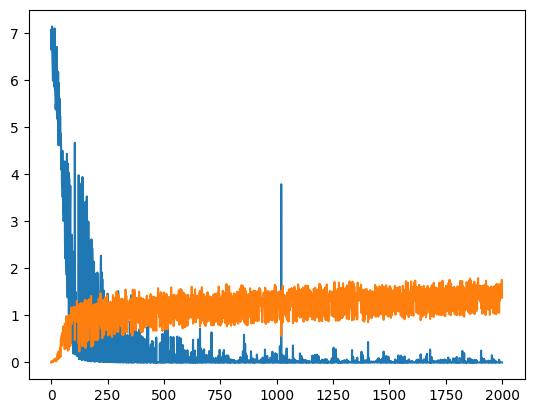

## Generate